Done.


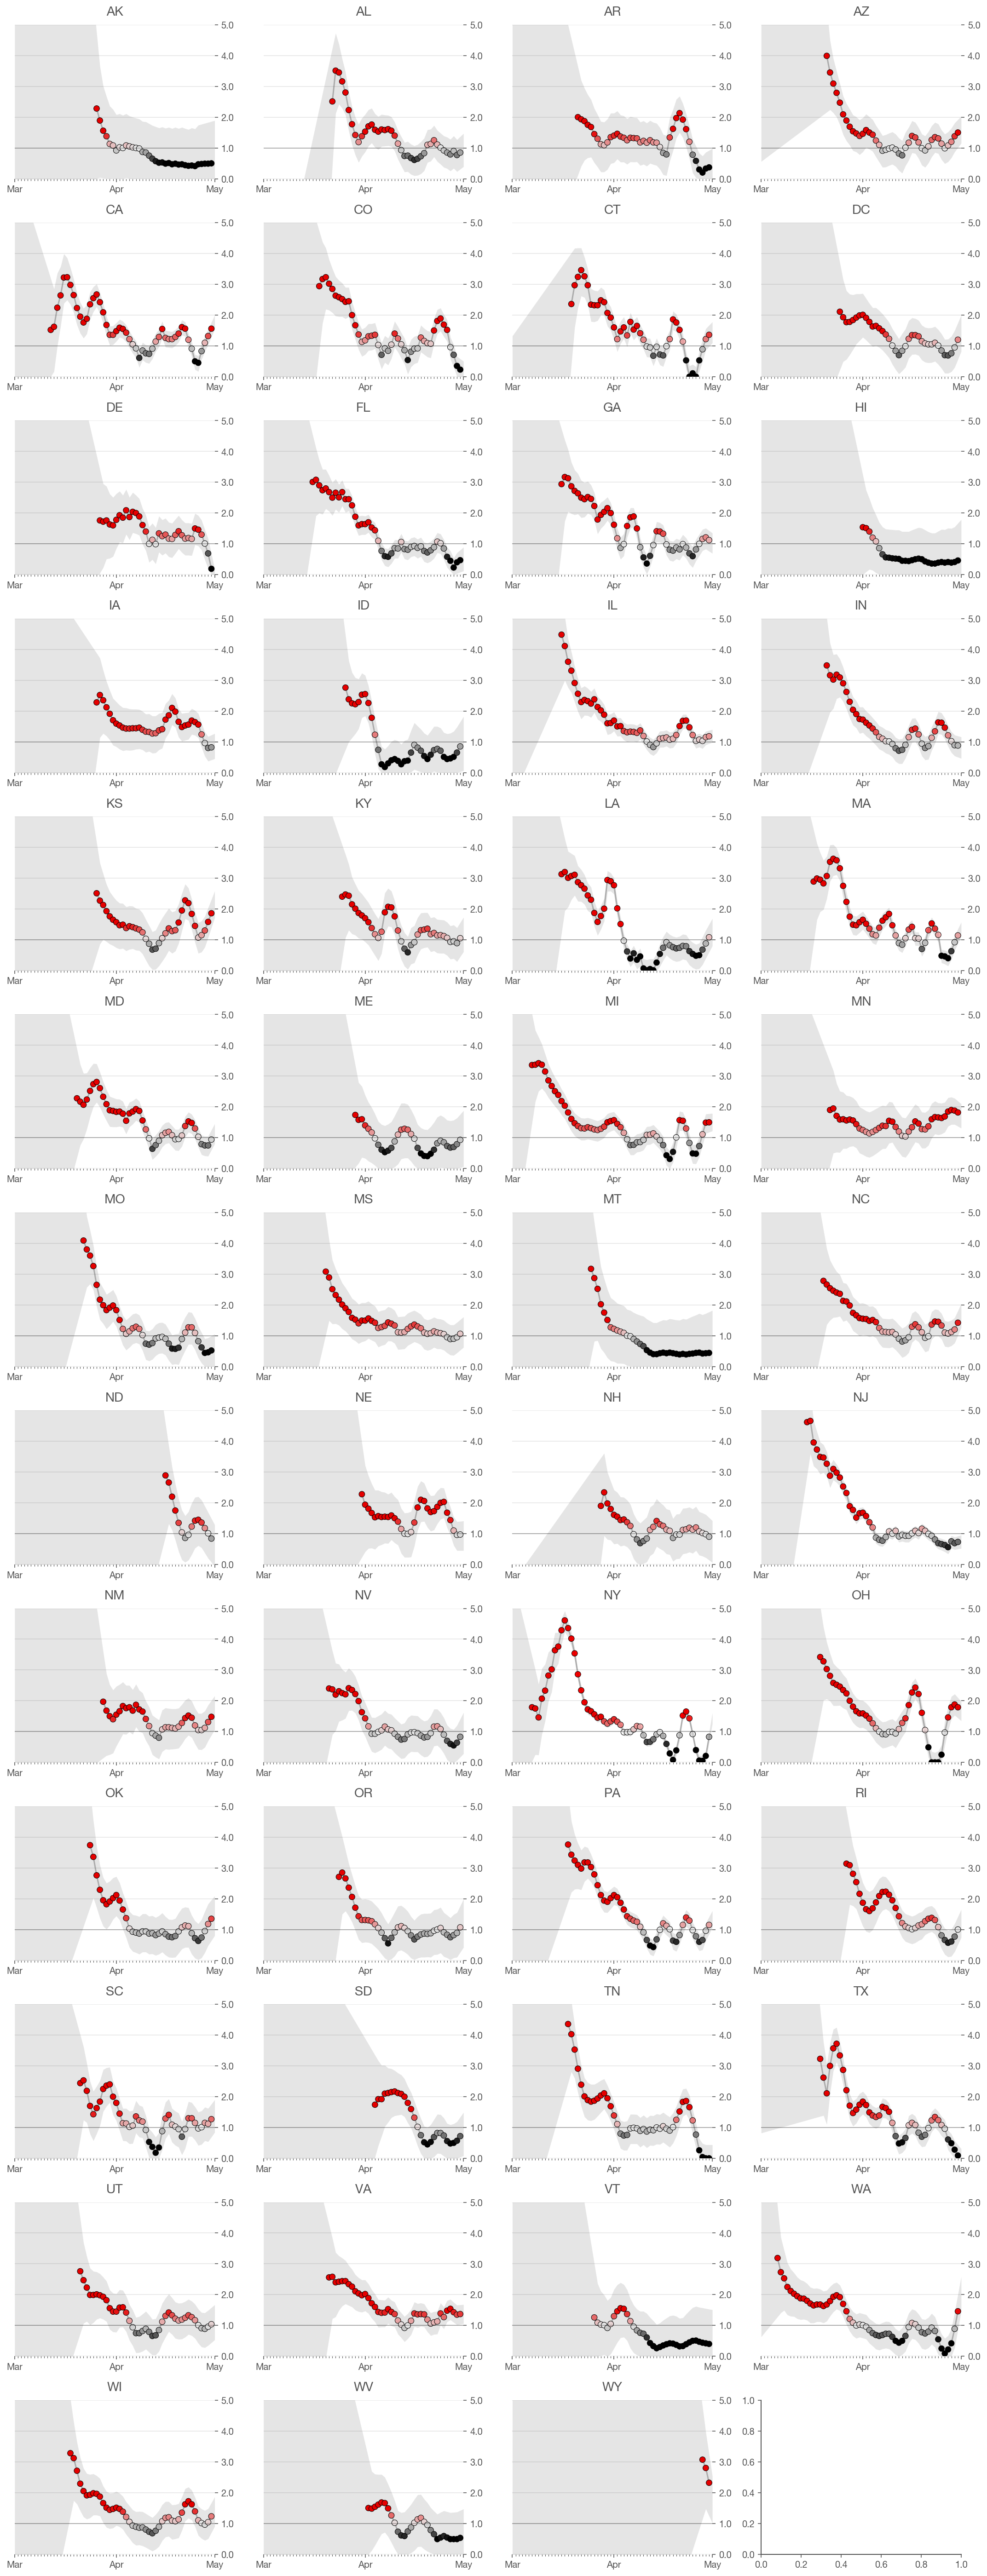

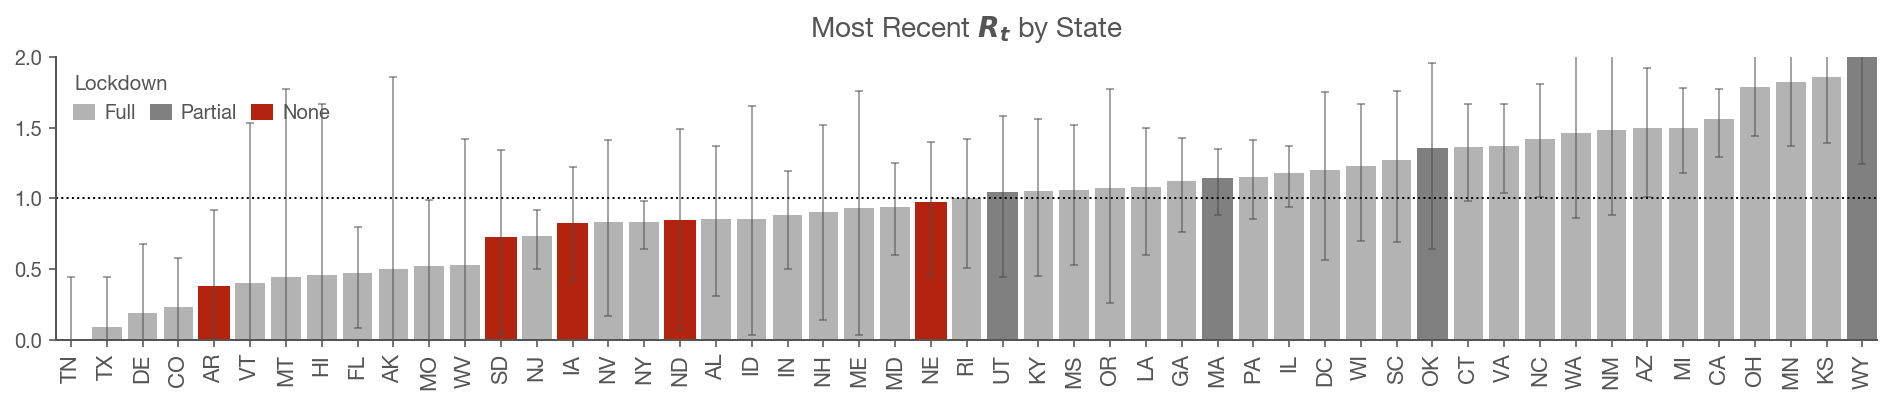

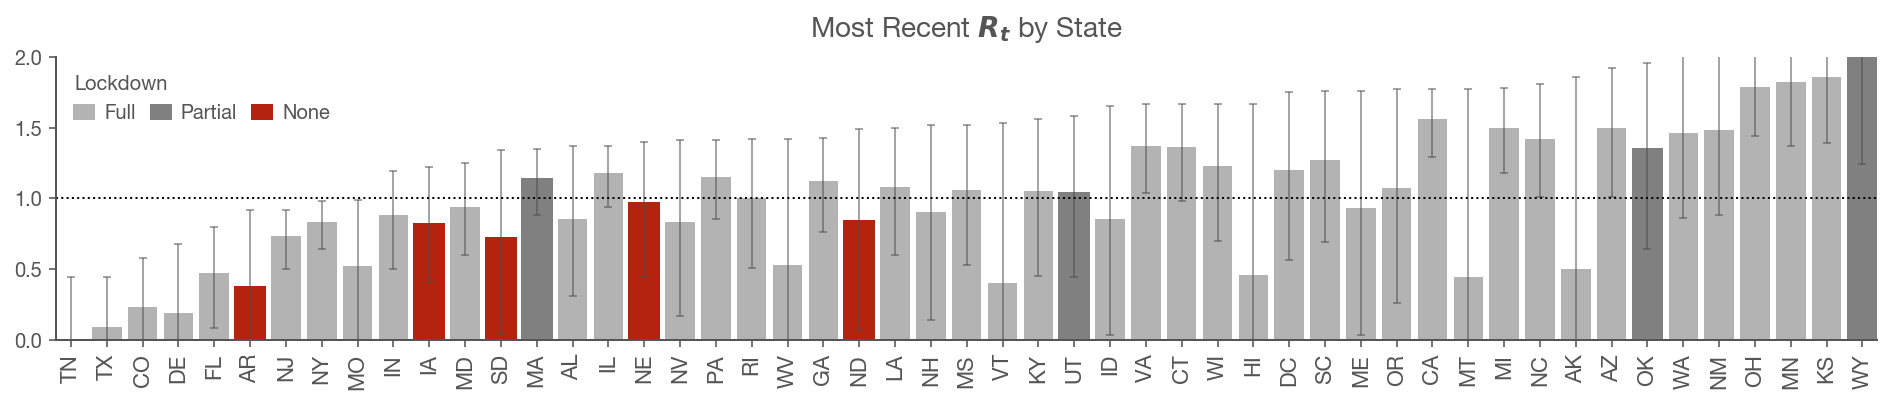

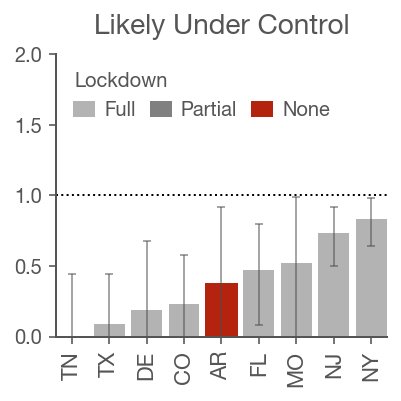

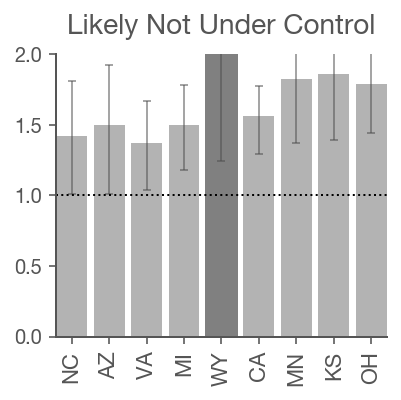

In [120]:
%run 'Realtime R0.ipynb'
#import import_ipynb
#import RealtimeR0

### Add before the "Choosing the optimal sigma" cell
## Break the notebook with this to avoid long calculation, only primary functions is required for importing
# raise SystemExit("STOP MASTER US NOTEBOOK HERE!")

In [121]:
#import requests

#state_name = 'ZA'

### OLD API
## Last complete stats, one day delayed
#url = 'https://api.covid19api.com/total/dayone/country/' + state_name
## Current daily stats, last day might not have updated, if duplicated do not use
##url = 'https://api.covid19api.com/dayone/country/' + state_name

#client = requests.request("GET", url)
#response = client.text
#data_all = pd.read_json(response, orient='columns')
#data_all['Date'] = data_all['Date'].dt.tz_localize(None)
#data_index = data_all.set_index('Date')

## If delayed, manually add last day from another known source
#day = pd.DataFrame({'Confirmed':4220}, index=pd.to_datetime(['2020-04-24']))
#data_index = data_index.append(day)

#states = data_index['Confirmed']
#states

In [233]:
# Notebook Automation
# https://github.com/yaananth/run-notebook
#!pip install nteract-scrapbook

#import uuid
#output = str(uuid.uuid4())

#import scrapbook as sb
#sb.glue("output", output)

In [234]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_all = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()
states_all = states_all.rename(columns={'total':'Total RSA'})

# ZA: single plot
state_name = 'Total RSA'

# filter data if required
#state_filter = states_all[:-1];
states = states_all
states.tail()

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Total RSA,source
51,2020-04-27,20200427,588.0,111.0,1353.0,902.0,31.0,26.0,17.0,31.0,1737.0,0.0,4793,https://twitter.com/drzwelimkhize/status/12548...
52,2020-04-28,20200428,616.0,113.0,1377.0,919.0,31.0,26.0,17.0,29.0,1870.0,0.0,4996,https://twitter.com/COVID_19_ZA/status/1255200...
53,2020-04-29,20200429,630.0,113.0,1408.0,956.0,31.0,31.0,17.0,29.0,2135.0,0.0,5350,https://sacoronavirus.co.za/2020/04/29/update-...
54,2020-04-30,20200430,647.0,116.0,1446.0,980.0,32.0,36.0,17.0,31.0,2342.0,0.0,5647,https://sacoronavirus.co.za/2020/04/30/update-...
55,2020-05-01,20200501,691.0,118.0,1507.0,1006.0,34.0,35.0,18.0,18.0,2507.0,0.0,5951,https://sacoronavirus.co.za/2020/05/01/update-...


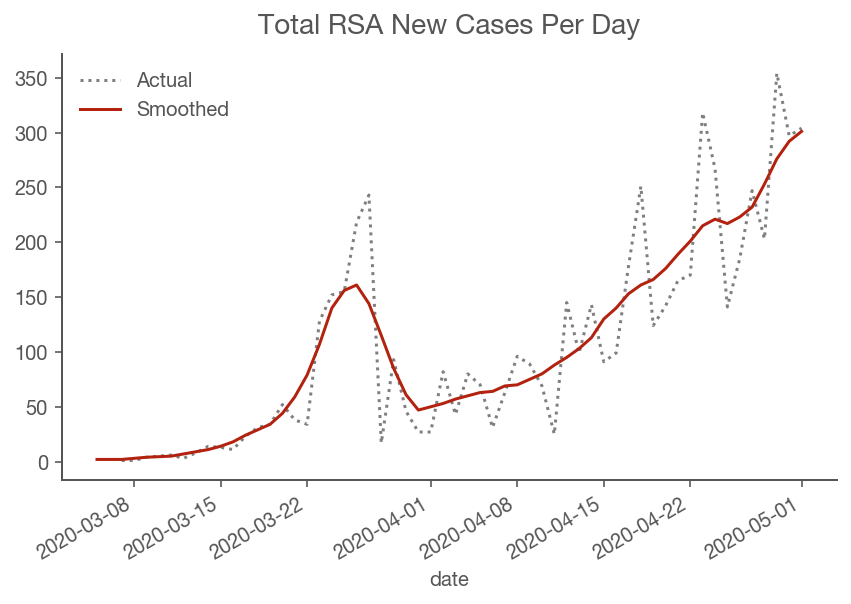

In [235]:
cases = pd.Series(states[state_name].values,index=states['date'])
original, smoothed = prepare_cases(cases, cutoff=2)

original.plot(title=f"{state_name} New Cases Per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [236]:
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

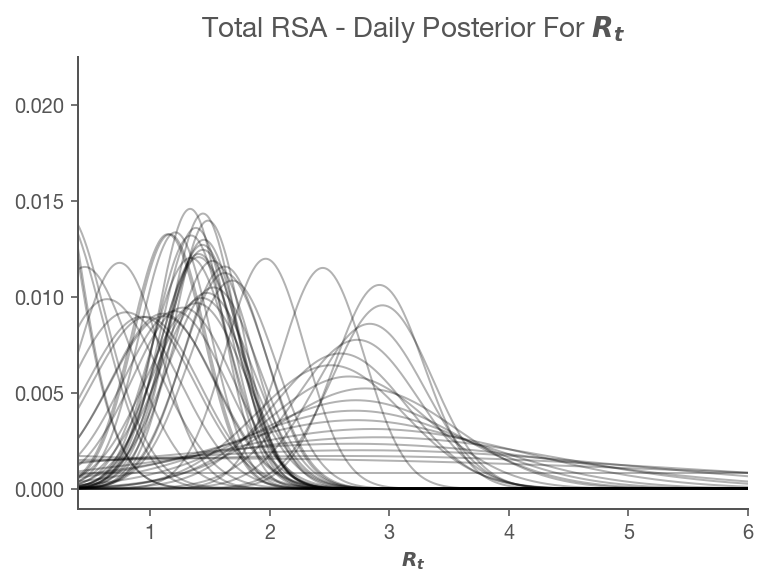

In [237]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior For $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [238]:
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

# US: Since we now use a uniform prior, the first datapoint is pretty bogus, so just truncating it here
# ZA: rename to single_result to add to final province plots again
single_result = result.drop(result.index[0])
single_result.tail()

,ML,Low_90,High_90
date,,,
2020-04-27,1.21,0.67,1.66
2020-04-28,1.38,0.86,1.83
2020-04-29,1.48,1.00,1.94
2020-04-30,1.44,0.95,1.87
2020-05-01,1.33,0.87,1.77


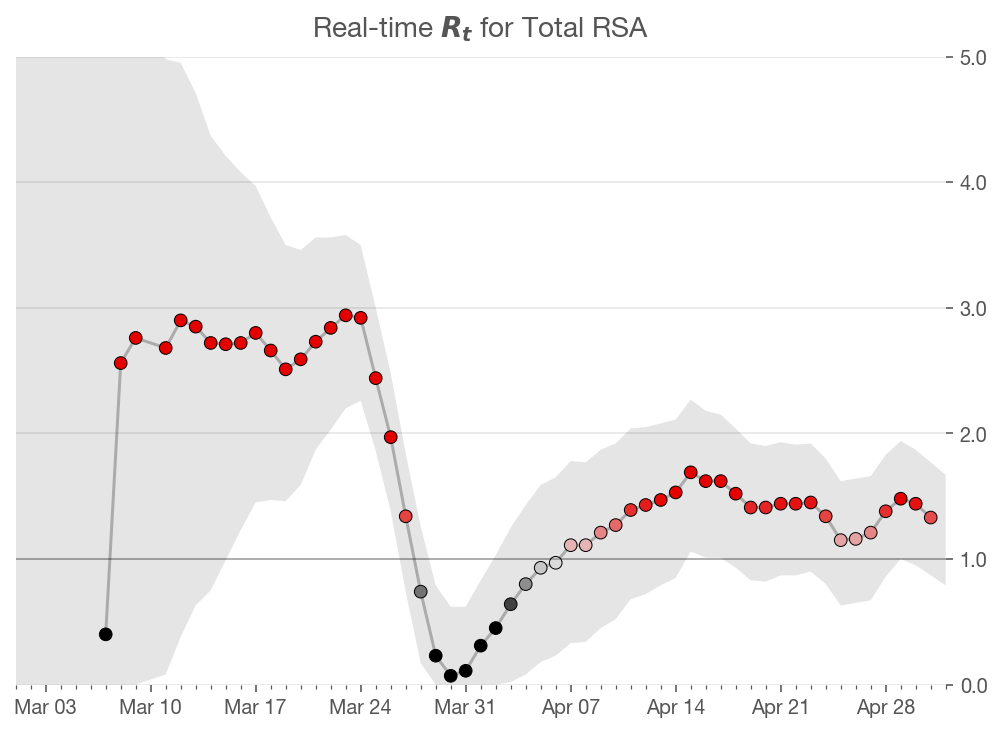

In [239]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(single_result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [240]:
# ZA: np.seterr(divide = 'ignore')

sigmas = np.linspace(1/20, 1, 20)

# ZA: only consider the official 9 provinces
states_to_process = list(states.columns.values[2:11])
# ZA: do not think the total RSA sigma needs to be included to find the province max later
# states_to_process.append('Total RSA') 

results = {}

for state_name in states_to_process:
    
    # --> ZA prepare data
    # ZA: Rt is very small for some provinces
    print(state_name)
    cases = pd.Series(states[state_name].values,index=states['date'])
    new, smoothed = prepare_cases(cases, cutoff=10)
    cut = 10
    
    # Rt for ZA is very small for some provinces
    # set threshold for smoothed data length at 3 to ensure posteriors can be calculated
    if len(smoothed) < 3:
        new, smoothed = prepare_cases(cases, cutoff=5)
        cut = 5
        if len(smoothed) < 3:
            new, smoothed = prepare_cases(cases, cutoff=2)
            cut = 2
            
            # ignore Rt further for slow growth provinces
            if len(smoothed) < 3:
                print('BREAK')
                clear_output(wait=True)
                continue
            
    print(cut)
    ## <-- ZA prepare data
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    try:
        for sigma in sigmas:
            posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
            result['posteriors'].append(posteriors)
            result['log_likelihoods'].append(log_likelihood)
    except:
        print('No available sigmas')
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done')

Done


EC
FS
GP
KZN
MP
WC


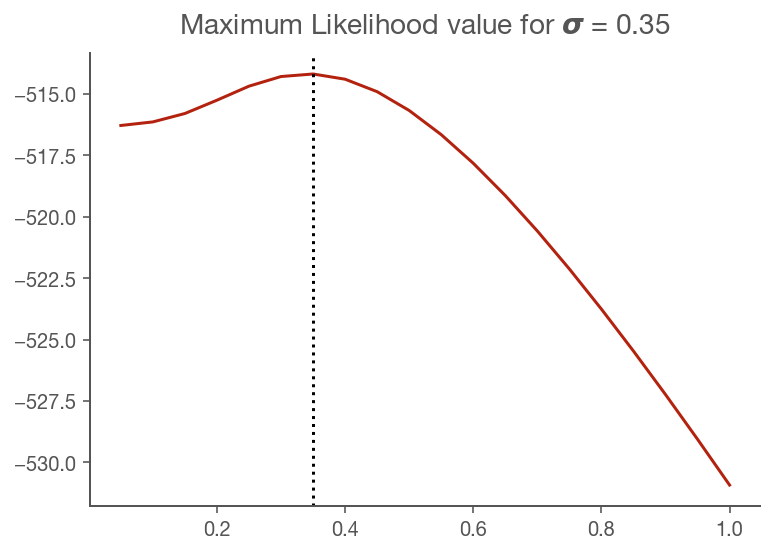

In [241]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    print(state_name)
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [242]:
final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    
    # ZA: add province index
    result.index = pd.MultiIndex.from_product([[state_name], result.index], names=['state','date'])
    
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

Done.


In [243]:
# US: This can be moved before the plots
# Since we now use a uniform prior, the first datapoint is pretty bogus, so just truncating it here
final_results = final_results.groupby('state').apply(lambda x: x.iloc[1:].droplevel(0))

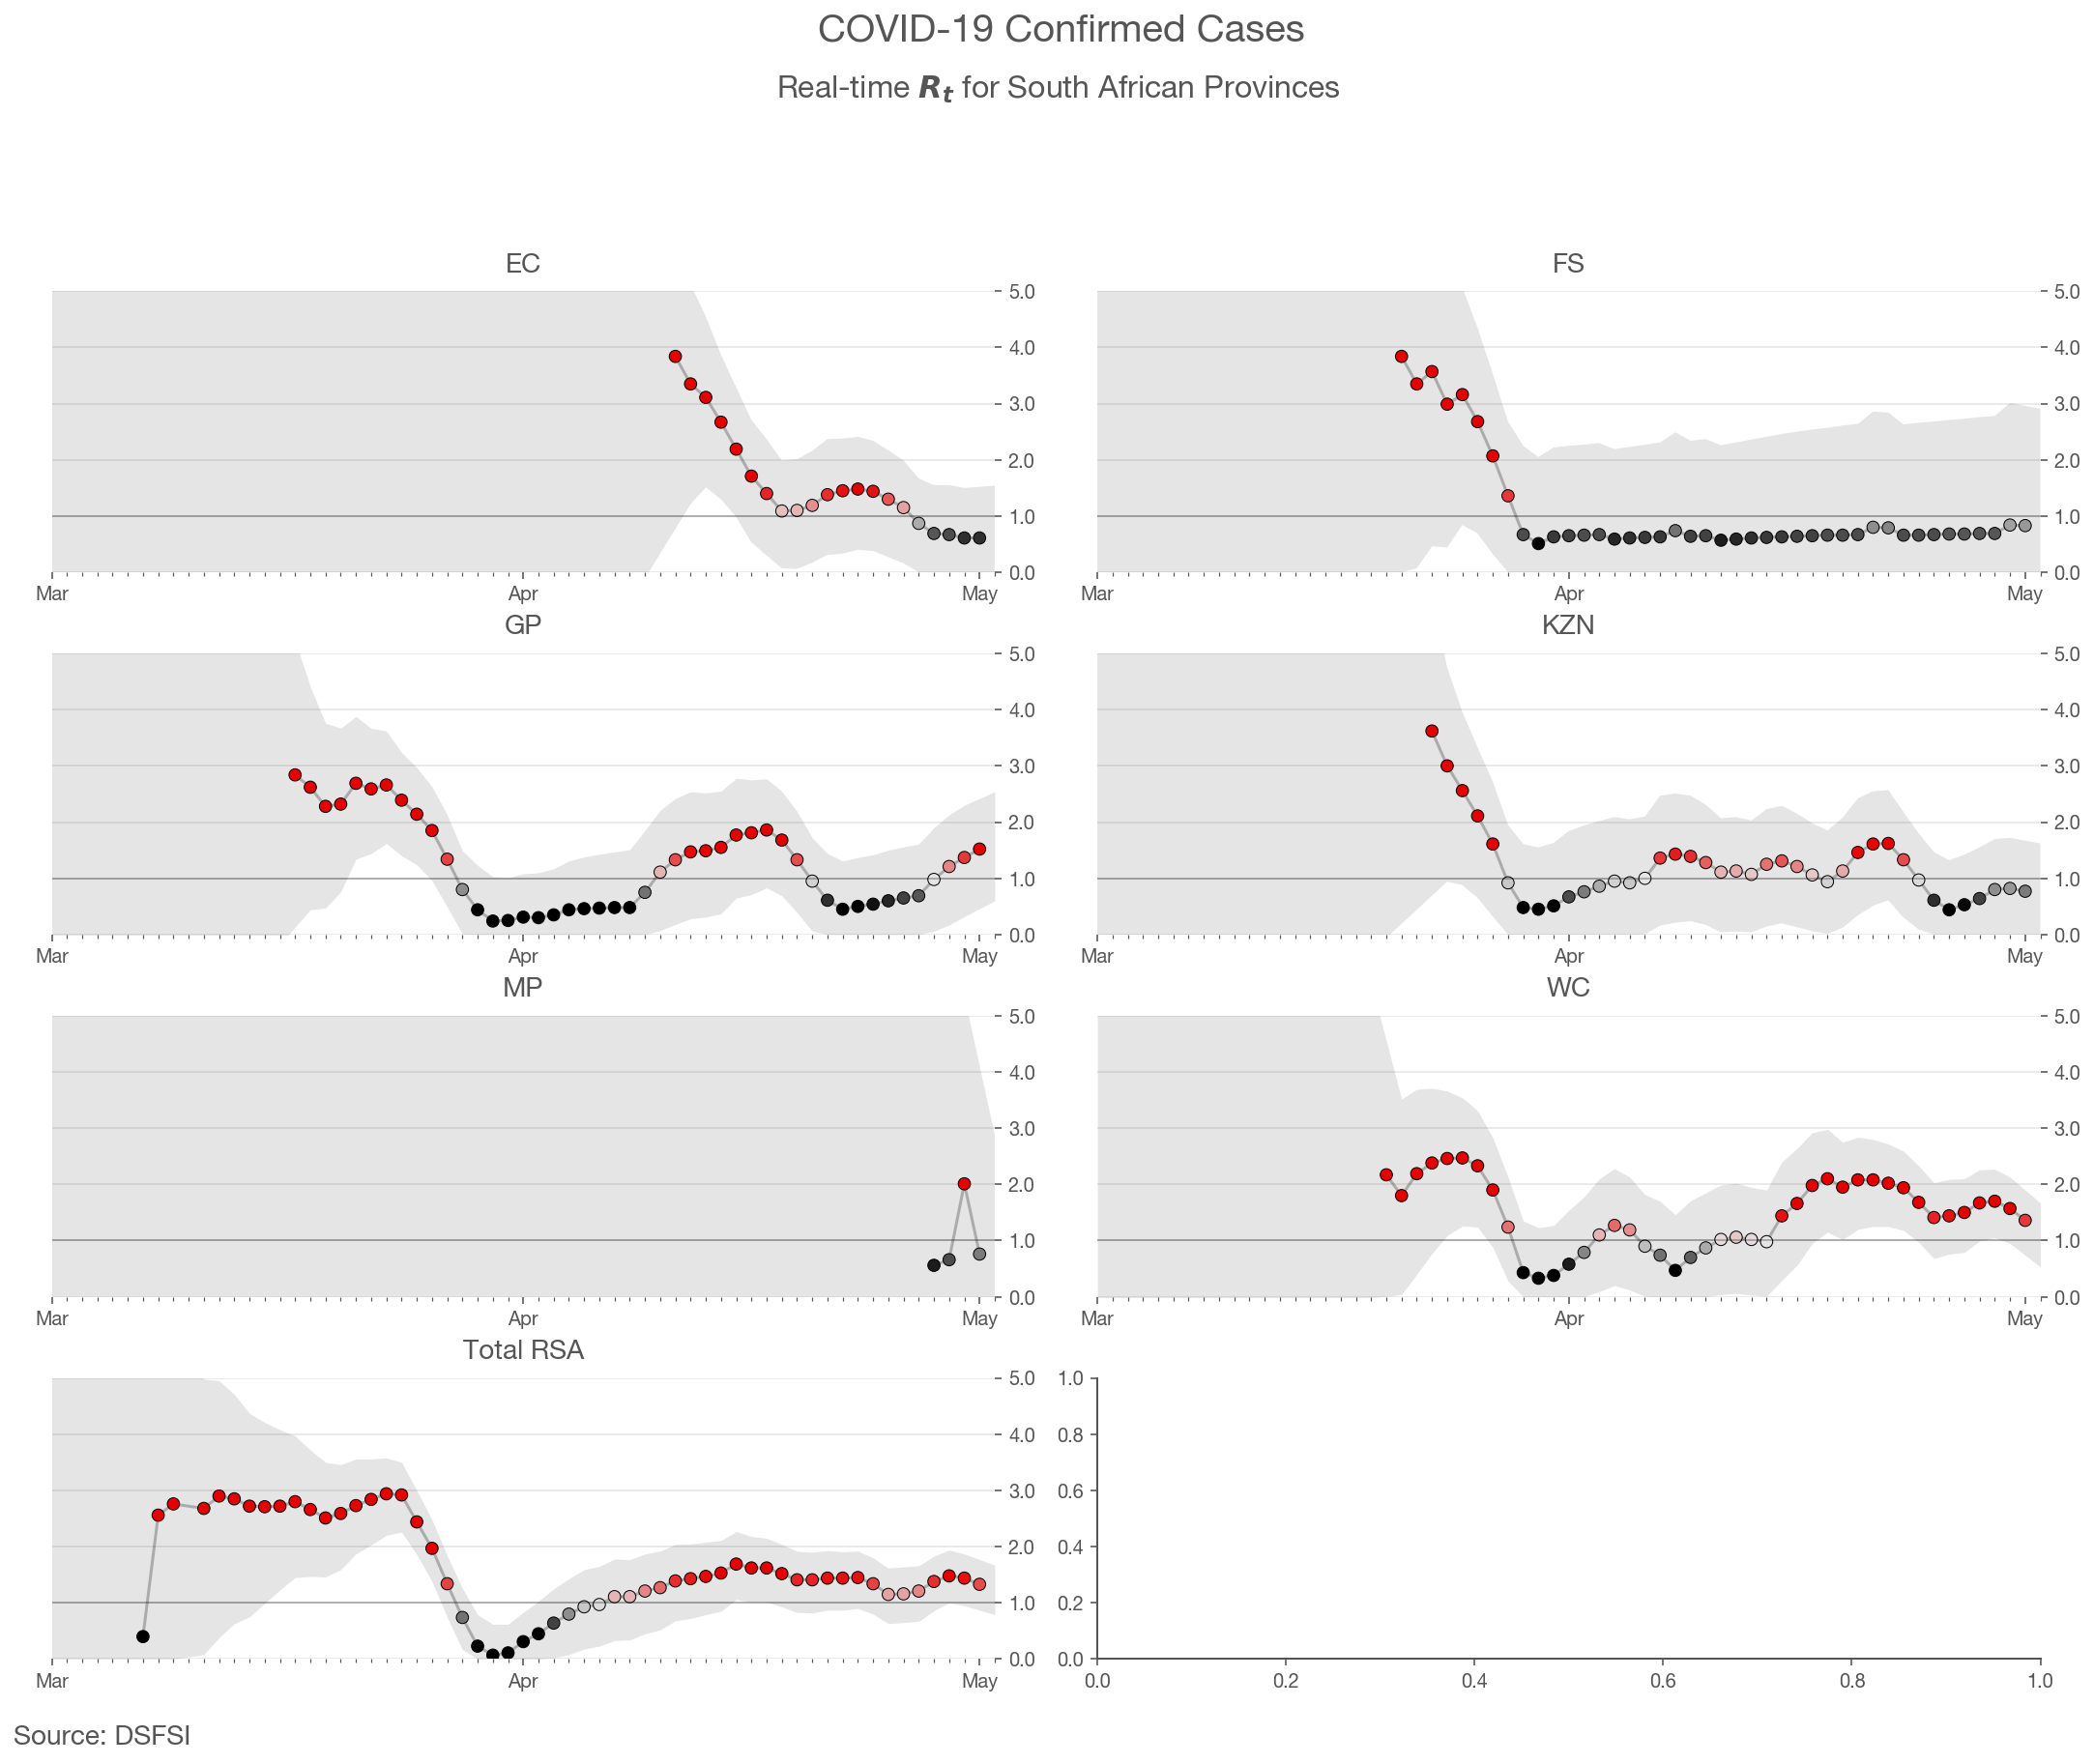

In [244]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols)) + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result, axes.flat[i], state_name)
plot_rt(single_result, axes.flat[i+1], 'Total RSA')
    
fig.tight_layout()
fig.text(0.385, 1.00, 'COVID-19 Confirmed Cases', size=20)
fig.suptitle(f'Real-time $R_t$ for South African Provinces', size=16)
fig.text(0, -0.02, 'Source: DSFSI', size=14, weight='demibold')
fig.subplots_adjust(top=0.85)
fig.set_facecolor('w')

In [245]:
# Uncomment the following line if you'd like to export the data
# ZA: select most likely and 90% fields
export_results = final_results[['ML', 'High_90', 'Low_90']]
export_results.to_csv('data/calc/calculated_r0_sa_provincial_cumulative.csv')

In [246]:
# ZA: South Arica data as of 2020/04/28
no_lockdown = [

]
partial_lockdown = [

]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [247]:
# ZA: df slighty different to US
mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

,ML,High_90,Low_90
state,,,
EC,0.61,1.52,0.00
FS,0.83,2.96,0.00
GP,1.52,2.42,0.46
KZN,0.77,1.67,0.00
MP,0.76,4.12,0.00
WC,1.36,1.90,0.74


In [248]:
# US data has broke primary notebook, thus copying the method
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

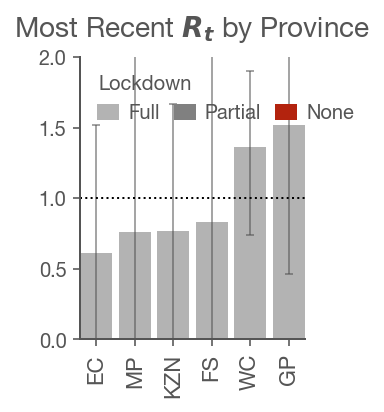

In [249]:
mr.sort_values('ML', inplace=True)
plot_standings(mr, title='Most Recent $R_t$ by Province');

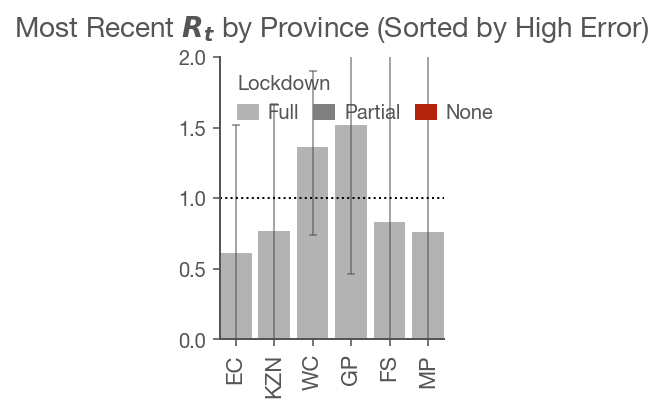

In [250]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr, title='Most Recent $R_t$ by Province (Sorted by High Error)');

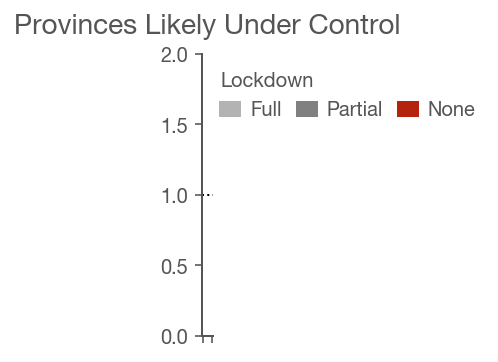

In [251]:
show = mr[mr.High_90.le(1.1)].sort_values('ML')
fig, ax = plot_standings(show, title='Provinces Likely Under Control');

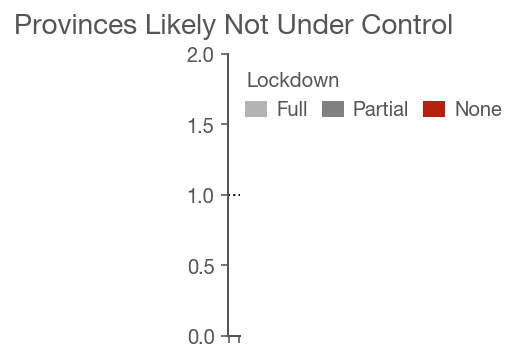

In [252]:
show = mr[mr.Low_90.ge(1.05)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Provinces Likely Not Under Control');